Import packages

In [1]:
import numpy as np
from jax import grad,jit,vmap
import jax.numpy as jnp
import jax.random as random
from jax.ops import index_update, index

In [2]:
from scipy.sparse.linalg import eigs,eigsh
from functools import partial
from scipy.sparse.linalg import LinearOperator, dsolve, spsolve
from scipy import linalg
from sklearn.preprocessing import scale
from scipy import sparse

In [3]:
import tensorflow as tf
from tensorflow.keras import datasets, models, layers
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
from tensorflow.image import flip_left_right, flip_up_down
from resnetpa import ResNetPreAct,rnpa_bottleneck_layer

In [4]:
import time
from tqdm import trange # short cut for tqdm(range())
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import sys
sys.path.append('/content/drive/MyDrive/colab')


Load data (first download them from the link)

In [7]:
training_lands = np.load('/traininglands_60.npy')
training_labels = np.load('/traininglabels_60.npy')

Data augmentation

In [8]:
n = 60
n_eivs = 3
np.random.seed(543)

aug_lands = flip_left_right(training_lands )

aug_lands2 = flip_up_down(training_lands )


def fliplabel_ho(ele):
  ele_new = ele.copy()
  for i in range(n_eivs):
    ele_new[2+4*i] = n-1 - ele_new[2+4*i]
  return ele_new
def fliplabel_ver(ele):
  ele_new = ele.copy()
  for i in range(n_eivs):
    ele_new[3+4*i] = n-1 - ele_new[3+4*i]
  return ele_new

aug_labels = [fliplabel_ho(ele) for ele in training_labels]
aug_labels = np.array(aug_labels)

aug_labels2 = [fliplabel_ver(ele) for ele in training_labels]
aug_labels2 = np.array(aug_labels2)




training_lands_expand = np.concatenate([training_lands,aug_lands,aug_lands2],axis=0)
training_labels_expand = np.concatenate([training_labels,aug_labels,aug_labels2],axis=0)


permu_ind = np.random.permutation(np.arange(0,len(training_lands_expand),1))

training_lands_expand = training_lands_expand[permu_ind]
training_labels_expand = training_labels_expand[permu_ind]

Auxiliary functions

In [9]:
@jit 
def Hamilton(V,X):
    """
    Calculate the Hamiltonian as an operator

    Arg:
        V: potential 
        X: a square matrix
    Return:
        The image of X under the Hamiltonian operator (-Laplacian + V)
    """
    X0 = (4 + V)*X
    X0 = index_update(X0, index[1:,:], X0[1:,:]-X[:-1,:])
    X0 = index_update(X0, index[:,1:], X0[:,1:]-X[:,:-1])
    X0 = index_update(X0, index[:-1,:], X0[:-1,:]-X[1:,:])
    X0 = index_update(X0, index[:,:-1], X0[:,:-1]-X[:,1:])
    return X0
class Hamilton_operator(LinearOperator):
  def __init__(self,n,V,dtype = np.float32):
    self.V = V
    self.shape = (n*n,n*n)
    self.dtype =np.dtype(dtype)
    self.n = n
  def _matvec(self, x):
    return Hamilton(self.V,x.reshape(self.n,self.n)).ravel()
  def _rmatvec(self,x):
    return Hamilton(self.V,x.reshape(self.n,self.n)).ravel()
    
def mean_variance(n,p):
  """
  calculate the mean and distance variance of a 2d distribution p
  mean = Expectation_{p}((x,y))
  variance = Var_{p}(|(x,y)-mean|^{2})

  Arg:
      p: a square numpy matrix which is a probability distribution.
      n: the edge length of the matrix.
  
  Return:
      The mean and variance of distribution p.
  """
  xc = np.arange(0,n,1)
  yc = np.arange(0,n,1)
  xv, yv = np.meshgrid(xc,yc)
  mean = np.array([np.sum(xv*p), np.sum(yv*p)])
  variance = np.sum(((xv - mean[0])**2)*p) + np.sum(((yv - mean[1])**2)*p)
  return mean,variance

The detector class

In [17]:
class Localization_landscape_detector:
  """
  The localization detector.

  Arg:
        key: a random key used to generate the samples
        n: the edge length of the square
        V_bar: the upper bound of the uniform distribution
        n_eivs: the number of the smallest eigenvalues and correponding eigenfunctions to calculate
  """
  def __init__(self, key, n=45, V_bar =3.0, n_eivs = 1):

    self.n = n
    self.key = key
    self.n_samples = 0
    self.V_bar = V_bar
    self.training_labels = None
    self.training_landscapes = None
    self.effective_potentials = None
    self.samples = []
    self.model = None
    self.history = None
    self.ratio = None
    self.n_eivs = n_eivs

  def potential_generate(self,n_samples):
    """
    Generating random uniform potentials in [0,V_bar]
    For each potential, also generate the landscape and store it in self.training_landscapes
    For each potential, also generate the first n_eivs eigenvalues, eigenfunctions' locations and store them in self.training_labels

    Arg:
        n_samples: number of potentials to generate
    """
    print('generating potential samples...')
    self.n_samples += n_samples
    self.samples = list(self.samples)
    for i in trange(self.n_samples):
      self.key,_ = random.split(self.key)
      self.samples.append(random.uniform(self.key,(self.n,self.n),minval = 0.0, maxval= self.V_bar))
    self.samples = jnp.array(self.samples)
    print('generating labels and landscapes...')
    labels_sci = []
    landscapes = []
    rhs = np.ones((self.n)**2,dtype=np.float32)
    for i in trange(self.n_samples):
      #print('here')
      Hamiltonian = Hamilton_operator(n=self.n,V=self.samples[i],dtype=np.float32)
      
      X2,exit_status = sparse.linalg.cg(Hamiltonian,rhs)[0].reshape((self.n,self.n)),sparse.linalg.cg(Hamiltonian,rhs)[1]
      if exit_status != 0: # the convergence does not exit succesfully
        print('warning: convergence not succeed at sample {}\n'.format(i))
      landscapes.append(X2)

      w, v = eigsh(Hamiltonian,k=self.n_eivs,which='SM',maxiter=1e3)
      
      for j in range(self.n_eivs):
        v2 = v[:,j].reshape(self.n,self.n)
        mean,variance = mean_variance(self.n,(v2**2)/np.sum(v2**2))
        labels_sci.append(w[j]*self.n/np.log(self.n))
        labels_sci += [np.sqrt(variance)*self.n/np.sqrt(np.log(self.n)),mean[0],mean[1]]

      
    labels_sci = np.array(labels_sci)
    self.training_labels = labels_sci.reshape(self.n_samples,4*self.n_eivs)
    self.training_landscapes = np.expand_dims(np.array(landscapes),-1)
    
  def generate_effective_potentials(self):
    """
    Generating the effective potential which equals the reciprocal of landscape function
    """
    self.effective_potentials = np.reciprocal(self.training_landscapes)
  @partial(jit,static_argnums=(0,))
  def gradient(self,V,X):
    return (V+4)*(Hamilton(V,X)-1)
  def landscape_function_loss(self, V, num_iter=100, eta=0.02, nesterov = False):
    """
    calculate the landscape function for potential V

    Args:
        V: n by n potential
        num_iter: only meaningful when nesterov is True. The number of iterations to use in the gradient descent step
        eta: only meaningful when nesterov is True. The learning rate to use in the gradient descent step
        nesterov: whether to use the nesterov's method, if False, then use the Conjugate Gradient iteration method

    Return:
        if nesterov is True, return the n by n landscape function; else, return the landscape and the iteration status
    """
    if nesterov:
      X0 = np.zeros((self.n,self.n))
      Y = np.zeros((self.n,self.n))
      gamma = 0.0
      for j in range(num_iter): # nesterov acceleration
        Z = X0 - eta*self.gradient(V,X0)
        X0 = Z + gamma*(Z-Y)
        Y = Z
        gamma = j/(j+3)
      return Z
    else:
      rhs = np.ones((self.n)**2,dtype=np.float32)
      Ham = Hamilton_operator(self.n,V)
      return (sparse.linalg.cg(Ham,rhs)[0].reshape((self.n,self.n)),sparse.linalg.cg(Ham,rhs)[1])

  def new_model(self):
    print('generate a new cnn model...')

    model = ResNetPreAct(nb_classes=4*self.n_eivs, input_shape=(self.n,self.n,1), 
                         layer1_params=(3,128,2),res_layer_params=(3,32,25),reg=0.0)

    self.model = model

  def train(self, ratio, epochs = 100 , verbose = 1, batch_size = 36, use_landscape = True):
    """
    Training the model

    Args:
        ratio: a number between 0,1 which is the portion of training data
        other parameters: parameters for training a keras model
    """
    if self.model == None:
      self.new_model()

    self.ratio = ratio

    model = self.model
    print('compling the model...')
    adam = tf.keras.optimizers.Adam()
    model.compile(optimizer=tf.keras.optimizers.SGD(0.001, momentum=0.9), 
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=['accuracy'])
    
    def schedule(epoch,lr):
      if epoch < 30:
        return 5e-3
      if epoch < 60:
        return 5e-4
      return 5e-5

    scheduler = tf.keras.callbacks.LearningRateScheduler(schedule)

    print('train the model with ratio:(1-ratio) train-test rate...')
    if use_landscape:
      self.history = model.fit(self.training_landscapes[:int(ratio*self.n_samples)],
                               self.training_labels[:int(ratio*self.n_samples)], 
                               epochs=epochs,
                               batch_size=batch_size,
                               verbose=verbose, 
                               validation_data=(self.training_landscapes[int(ratio*self.n_samples):], 
                                                self.training_labels[int(ratio*self.n_samples):]),
                               callbacks = [scheduler])
    else:
      self.history = model.fit(self.effective_potentials[:int(ratio*self.n_samples)],
                               self.training_labels[:int(ratio*self.n_samples)],
                               epochs=epochs,
                               batch_size=batch_size,
                               verbose=verbose, 
                               validation_data=(self.effective_potentials[int(ratio*self.n_samples):],
                                          self.training_labels[int(ratio*self.n_samples):]),
                               callbacks = [scheduler])
    self.model = model
  def plot_loss(self):
    """
    ploting the training process
    """
    plt.figure()
    plt.plot(self.history.history['loss'],label='loss')
    plt.plot(self.history.history['val_loss'],label='val_loss')
    plt.legend()
    plt.show()

  def plot_test(self,n_egs,key):
    """
    plot some test examples

    Args:
        n_egs: number of examples
        key: random seed used to generate the n_egs examples
    """
    if self.ratio == None:
      self.ratio = 0.80
    test_indics = random.choice(key,jnp.array(range(int(self.ratio*self.n_samples),self.n_samples )),(n_egs,))
    predict_coor = self.model.predict(self.training_landscapes[test_indics,:])
    eiv_order = [i for i in range(1,self.n_eivs+1)]

    for j in range(len(test_indics)):
      X2 = self.training_landscapes[test_indics[j],:][:,:,0]
      plt.figure(figsize=(5,5))
      plt.imshow(X2/np.max(X2),cmap='jet',aspect='auto' )
      plt.colorbar()
      for i in range(self.n_eivs):
        radius =  self.training_labels[test_indics[j],1+4*i] * np.sqrt(np.log(self.n))/self.n
        plt.text(self.training_labels[test_indics[j],2+4*i],self.training_labels[test_indics[j],3+4*i],str(eiv_order[i]),c='black',fontsize=24) 
        plt.scatter(self.training_labels[test_indics[j],2+4*i],
                    self.training_labels[test_indics[j],3+4*i],
                    s=490+360*radius**2,
                    color="none", 
                    edgecolor="black",
                    marker='s')

        radius_pred = predict_coor[j][1+4*i]*np.sqrt(np.log(self.n))/self.n
        plt.text(predict_coor[j][2+4*i],predict_coor[j][3+4*i],str(eiv_order[i]),c='white',fontsize=24) 
        plt.scatter(predict_coor[j][2+4*i],
                    predict_coor[j][3+4*i],
                    s=490+360*radius_pred**2,
                    color="none", 
                    edgecolor="white",
                    marker='s')
      plt.show()
    return predict_coor, self.training_labels[test_indics,:]
  def predict(self,V):
    land = np.expand_dims(self.landscape_function_loss(V)[0],-1)
    return self.model.predict(np.array([land]))



Training the model

Option1: Train the model from scratch

In [28]:
key = random.PRNGKey(123)
detector = Localization_landscape_detector(key=key,n=60, V_bar=10. ,n_eivs=1) 
detector.n_samples = len(training_lands_expand)
detector.training_landscapes = training_lands_expand
detector.training_labels = training_labels_expand[:,:4]

In [ ]:
detector.train(0.80,epochs=100,verbose=1,use_landscape=True,batch_size=32)
detector.plot_loss()

Option2: Use the pretrained model

In [ ]:
model = tf.keras.models.load_model('/Model/')
model.summary()

In [18]:
key = random.PRNGKey(123)
detector = Localization_landscape_detector(key=key,n=60, V_bar=10.,n_eivs=1) 
detector.n_samples = len(training_lands_expand)
detector.training_landscapes = training_lands_expand
detector.training_labels = training_labels_expand[:,:4]
detector.model = model

Plot the result on ten testing examples

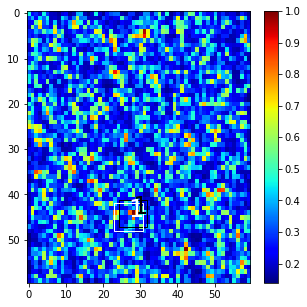

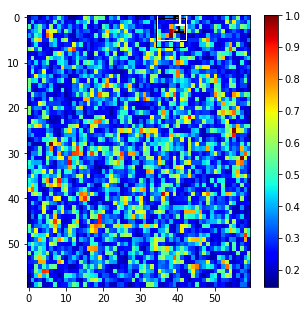

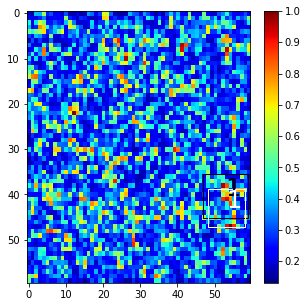

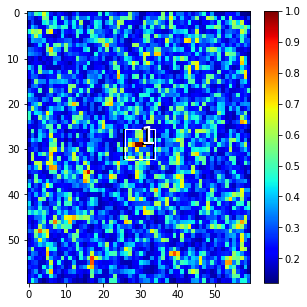

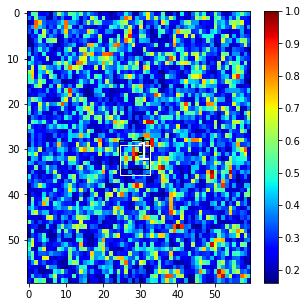

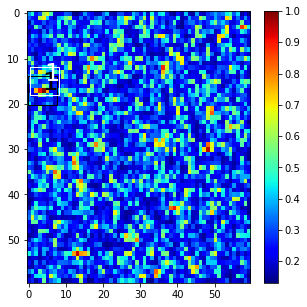

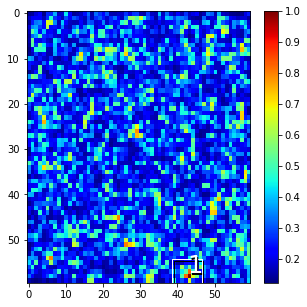

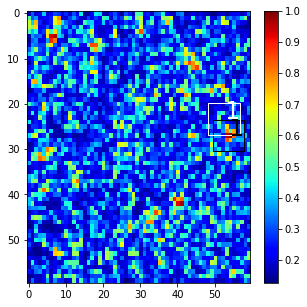

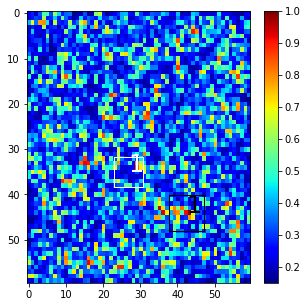

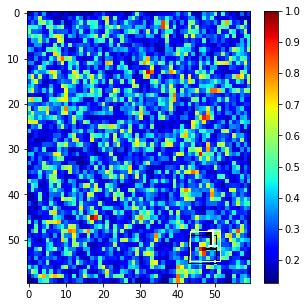

(array([[29.607834 , 27.78852  , 26.802794 , 45.01322  ],
        [30.589218 , 30.790453 , 38.359886 ,  1.8378906],
        [30.28136  , 47.416588 , 53.129677 , 42.937912 ],
        [27.375822 , 30.477255 , 29.97274  , 28.818493 ],
        [31.270924 , 32.230824 , 28.639824 , 32.39908  ],
        [27.857224 , 27.71668  ,  4.2225246, 14.907883 ],
        [26.322247 , 29.94571  , 42.54133  , 57.377983 ],
        [25.617535 , 35.89779  , 52.623417 , 23.353647 ],
        [30.379902 , 31.552652 , 26.832794 , 35.03515  ],
        [29.512196 , 31.975525 , 47.345478 , 51.44397  ]], dtype=float32),
 array([[29.93128642, 26.08537447, 27.98531932, 44.19618397],
        [30.30711172, 29.94078832, 38.18001056,  3.33334766],
        [30.3295878 , 60.34931283, 52.96082661, 40.38301172],
        [27.25186239, 32.37653703, 29.44689596, 28.92810867],
        [30.98019213, 31.30102805, 28.35351551, 31.17282823],
        [27.94921123, 29.44084867,  3.63400397, 17.00360873],
        [26.0168783 , 29.002260

In [19]:
detector.plot_test(10, key)